# Kaggle Titanic survival - Bagging

'Bagging' (bootstrap aggregation') is a simple but powerful method for improving accuracy of a model, and for getting a measure of model uncertainty.

The principle is simple: we train *n* neural nets all using different bootstrapped samples (sampling with replacement) from the training set. We then use the mean probability of classification from the ensemble of models.

Breiman, L. Bagging Predictors. Machine Learning 24, 123–140 (1996). https://doi.org/10.1023/A:1018054314350

This method may provide better performance than Monte-Carlo Dropout (see separate notebook), but is signficantly more computationally expensive as training needs to be repeated for each net in the ensemble.


In [ ]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Load modules

In [2]:
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

## Download data if not previously downloaded

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to scale data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [4]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc
    

## Load data

In [5]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

# Set up neural net

In [6]:
def make_net(number_features, learning_rate=0.003):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Define layers
    inputs = layers.Input(shape=number_features)
    dropout_0 = layers.Dropout(0.2)(inputs)
    
    dense_1 = layers.Dense(240, activation='relu')(dropout_0)
    dropout_1 = layers.Dropout(0.2)(dense_1)
    
    dense_2 = layers.Dense(50, activation='relu')(dropout_1)
    dropout_2 = layers.Dropout(0.2)(dense_2)
  
    outputs = layers.Dense(1, activation='sigmoid')(dropout_2)
    
    
    net = Model(inputs, outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net


## Show summary of the model structure

Here we will create a model with 10 input features and show the structure of the model as  atable and as a graph.

In [7]:
model = make_net(10)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 240)               2640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51    

Note that the plot of the model shows how the imput layer is connected to both the first dense layer and the concatenation layer prior to the output.

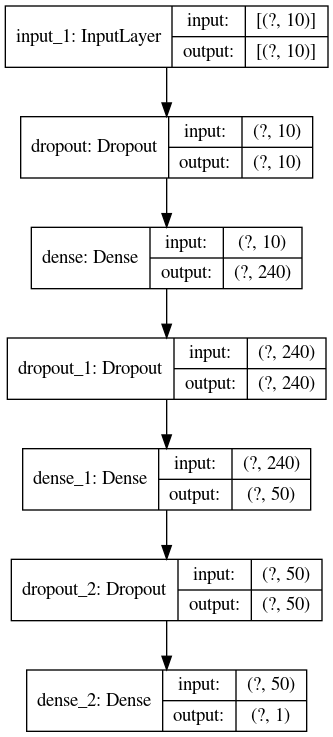

In [8]:
# If necessary conda install pydot and graphviz
keras.utils.plot_model(model, "titanic_tf_model.png", show_shapes=True)

# Training a single model

In [9]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size = 0.25)

# Scale data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

# Define network
number_features = X_train_sc.shape[1]
single_model = make_net(number_features)

# Train model
single_model.fit(X_train_sc,
            y_train,
            epochs=100,
            batch_size=32,
            verbose=0)

## Training an ensemble of models

Training is as a single model, but we use bootstrap sampling (sampling with replacement) to create different training sets.

Here we will use a fixed number (25) of nets. In practice this number should be a adjusted until a plateau in performance is reached. It is also possible to vary the bottstrap saple size - here we fix the sample size to be the same size as the training set.

In [10]:
number_of_nets = 25
training_set_size = len(X_train_sc)
sample_size = training_set_size

# Create and train models
models = []
number_features = X_train_sc.shape[1]
for i in range (number_of_nets):
    # Set up models
    print (f'Training model {i+1} of {number_of_nets}')
    model = make_net(number_features)
    # Get samples of training data
    indexes = np.random.choice(range(training_set_size), sample_size)
    resampled_X_train_sc = X_train_sc[indexes]
    resampled_y_train = y_train[indexes]
    # Fit model
    model.fit(resampled_X_train_sc,
            resampled_y_train,
            epochs=100,
            batch_size=32,
            verbose=0)
    # Add model to list of models
    models.append(model)

Training model 1 of 25
Training model 2 of 25
Training model 3 of 25
Training model 4 of 25
Training model 5 of 25
Training model 6 of 25
Training model 7 of 25
Training model 8 of 25
Training model 9 of 25
Training model 10 of 25
Training model 11 of 25
Training model 12 of 25
Training model 13 of 25
Training model 14 of 25
Training model 15 of 25
Training model 16 of 25
Training model 17 of 25
Training model 18 of 25
Training model 19 of 25
Training model 20 of 25
Training model 21 of 25
Training model 22 of 25
Training model 23 of 25
Training model 24 of 25
Training model 25 of 25


In [11]:
y_probas_bagging = np.stack(
        [models[i](X_test_sc) for i in range (number_of_nets)])

Get mean probabilities, and classify those with mean >= 0.5 as surviving.

In [12]:
y_proba_bagging = y_probas_bagging.mean(axis=0)
y_predict_bagging = y_proba_bagging >= 0.5
y_predict_bagging = y_predict_bagging.flatten()

Get normal predictions from single model

In [13]:
# Get normal predictions (single model) 
y_proba = single_model.predict(X_test_sc)
y_predict = y_proba >= 0.5
y_predict = y_predict.flatten()

Show accuracy scores (we are doing a single test set here; in practice k-fold validation should be used).

In [14]:
accuracy = np.mean(y_predict == y_test)
accuracy_bagging = np.mean(y_predict_bagging == y_test)
print (f'Accuracy of single net {accuracy:0.2f}')
print (f'Accuracy of bagged nets {accuracy_bagging:0.2f}')

Accuracy of single net 0.82
Accuracy of bagged nets 0.83


Plot comparisons of dropout method and standard method.

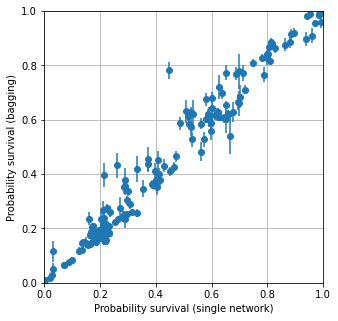

In [15]:
import matplotlib.pyplot as plt
y_error = y_probas_bagging.std(axis=0)/np.sqrt(number_of_nets)
fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(y_proba, y_proba_bagging, yerr = y_error, fmt='o')
ax.grid()
ax.set_xlabel('Probability survival (single network)')
ax.set_ylabel('Probability survival (bagging)')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Show variation in prediction (across the dropout replicates) depending on probability of survival.

Here we will use standard error of the mean as one measure of uncertainty. Note how uncertainty is not even - there is less variation in prediction of those with high probability of survival compared with those with lower probability of survival.

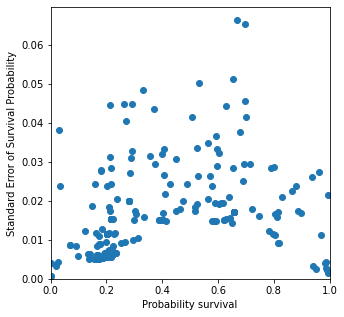

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_proba, y_error)
ax.set_xlabel('Probability survival')
ax.set_ylabel('Standard Error of Survival Probability')
ax.set_xlim(0,1)
ax.set_ylim(0)
plt.show()